In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

In [3]:
import dis2p.dis2pvae as dvae
import dis2p.dis2pvi as dvi

[2023-11-10 07:56:56,225] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 0


In [4]:
import scvi
import scanpy as sc
import pandas as pd
from datetime import datetime

def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats
    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

adata = scvi.data.heart_cell_atlas_subsampled()

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [5]:
# train params
epochs = 400
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

dvi.Dis2pVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
model = dvi.Dis2pVI(adata, n_layers=n_layers)
model.train(**train_dict)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 1c.3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-8391e223-da74-0458-e121-783edc78bf21/2/0]
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  

Epoch 142/400:  36%|███▌      | 142/400 [21:16<38:39,  8.99s/it, v_num=1, loss_validation=2.16e+3, x_0_validation=293, x_1_validation=297, x_2_validation=299, x_3_validation=296, x_4_validation=298, rec_x_cf_validation=475, z_1_validation=10.9, z_2_validation=11.4, z_3_validation=12, z_4_validation=10.8, ce_validation=0.915, acc_validation=0.996, f1_validation=0.996, adv_ce_validation=1.31, adv_acc_validation=0.597, adv_f1_validation=0.597, loss_train=2.01e+3, x_0_train=272, x_1_train=280, x_2_train=279, x_3_train=279, x_4_train=280, rec_x_cf_train=455, z_1_train=11.5, z_2_train=11.6, z_3_train=12, z_4_train=11.1, ce_train=0.916, acc_train=0.995, f1_train=0.995, adv_ce_train=0.868, adv_acc_train=0.562, adv_f1_train=0.562]    
Monitored metric loss_validation did not improve in the last 45 records. Best score: 2150.955. Signaling Trainer to stop.


In [9]:
model.save(f"{pre_path}/{model_name}")

In [10]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = dvi.Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

INFO     File                                                                                                      
         models/dis2p/2023-11-10,dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_w
         eight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                


In [11]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

---UMAP for dis2p_Z_0---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12030. The TBB threading layer is disabled.
  warnings.warn(problem)
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = sca

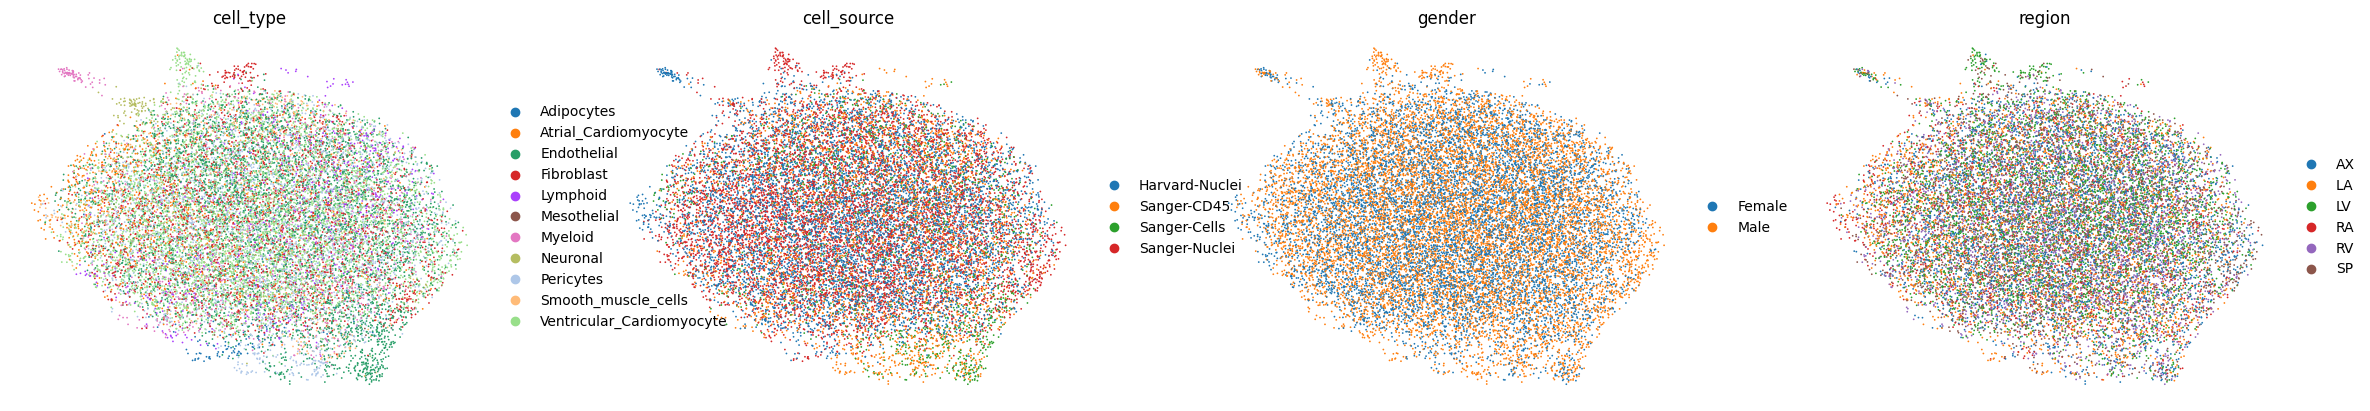

---UMAP for dis2p_Z_1---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


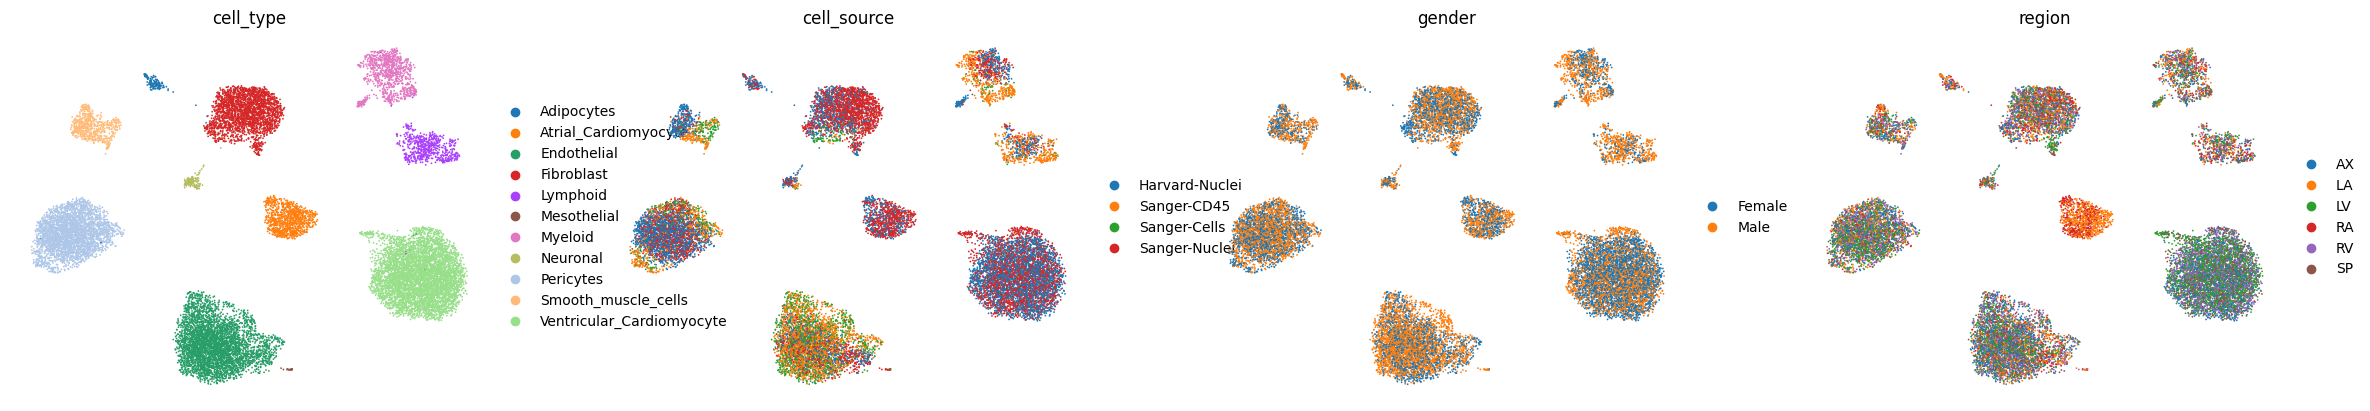

---UMAP for dis2p_Z_2---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


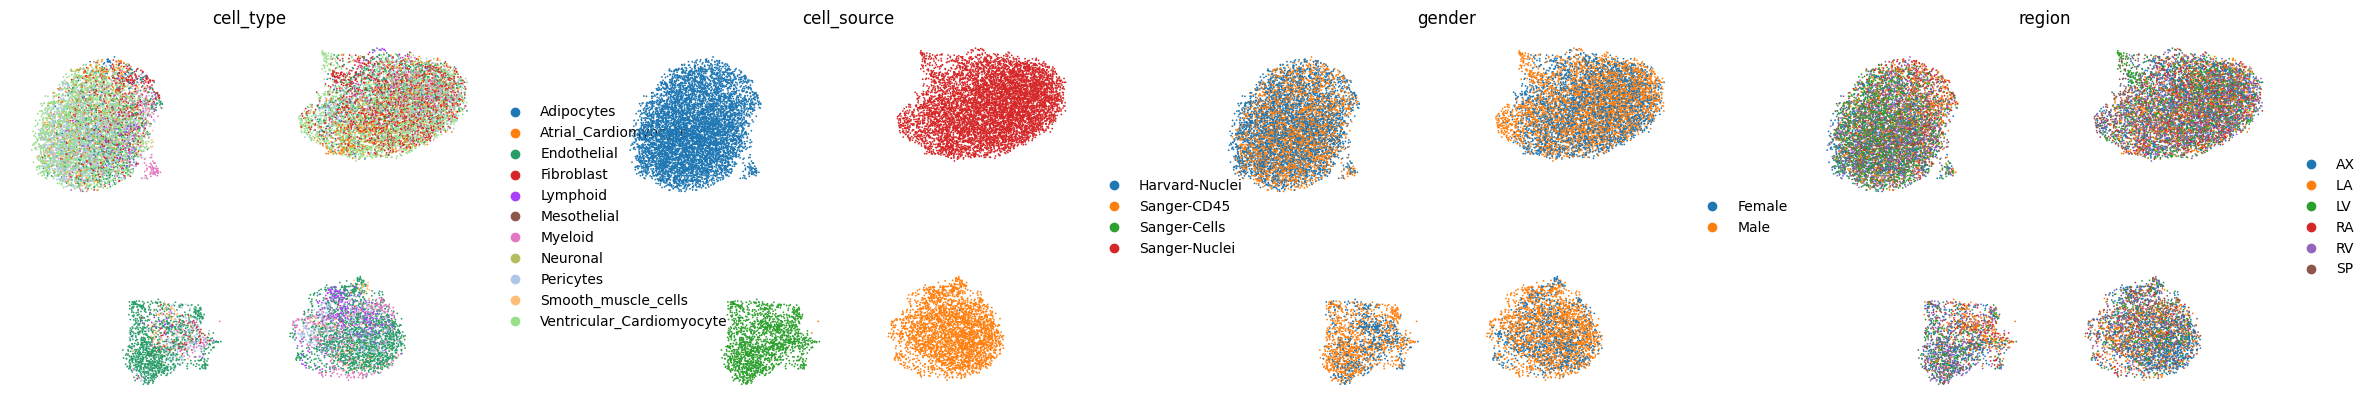

---UMAP for dis2p_Z_3---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


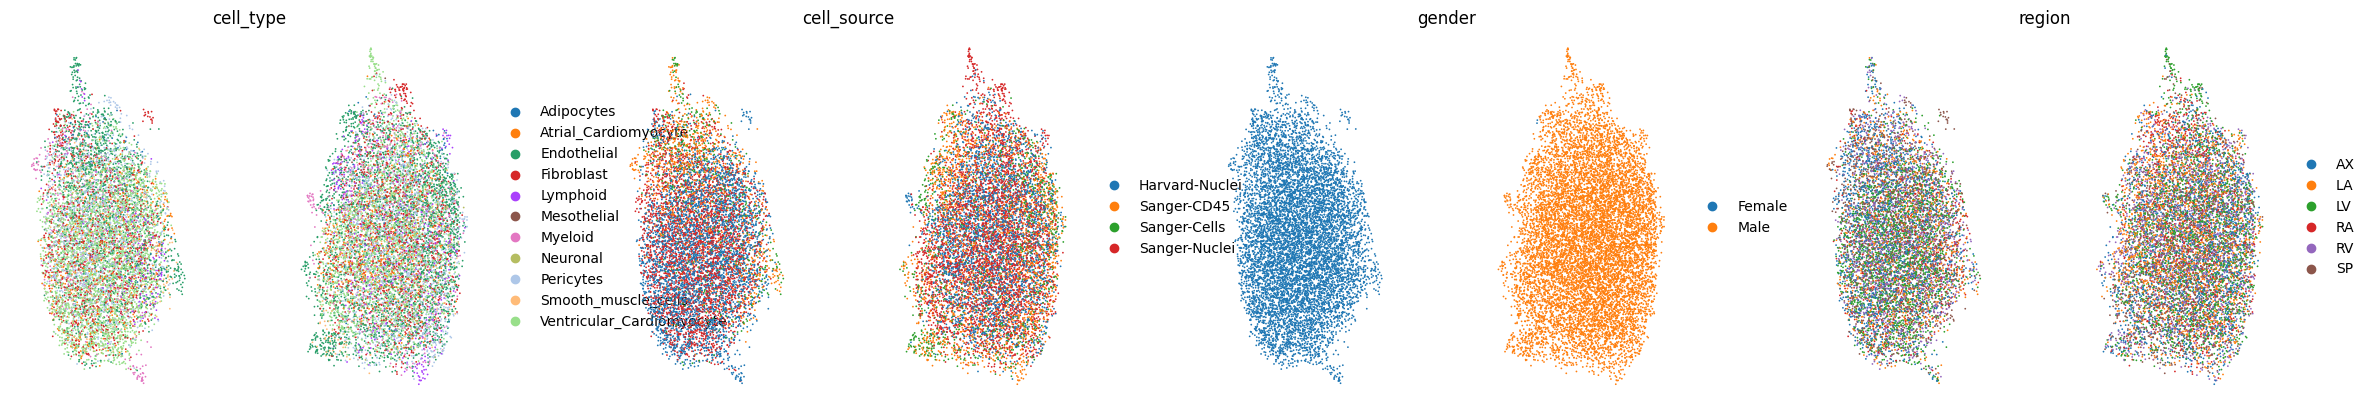

---UMAP for dis2p_Z_4---


/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ml19/miniconda3/envs/multimodal/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


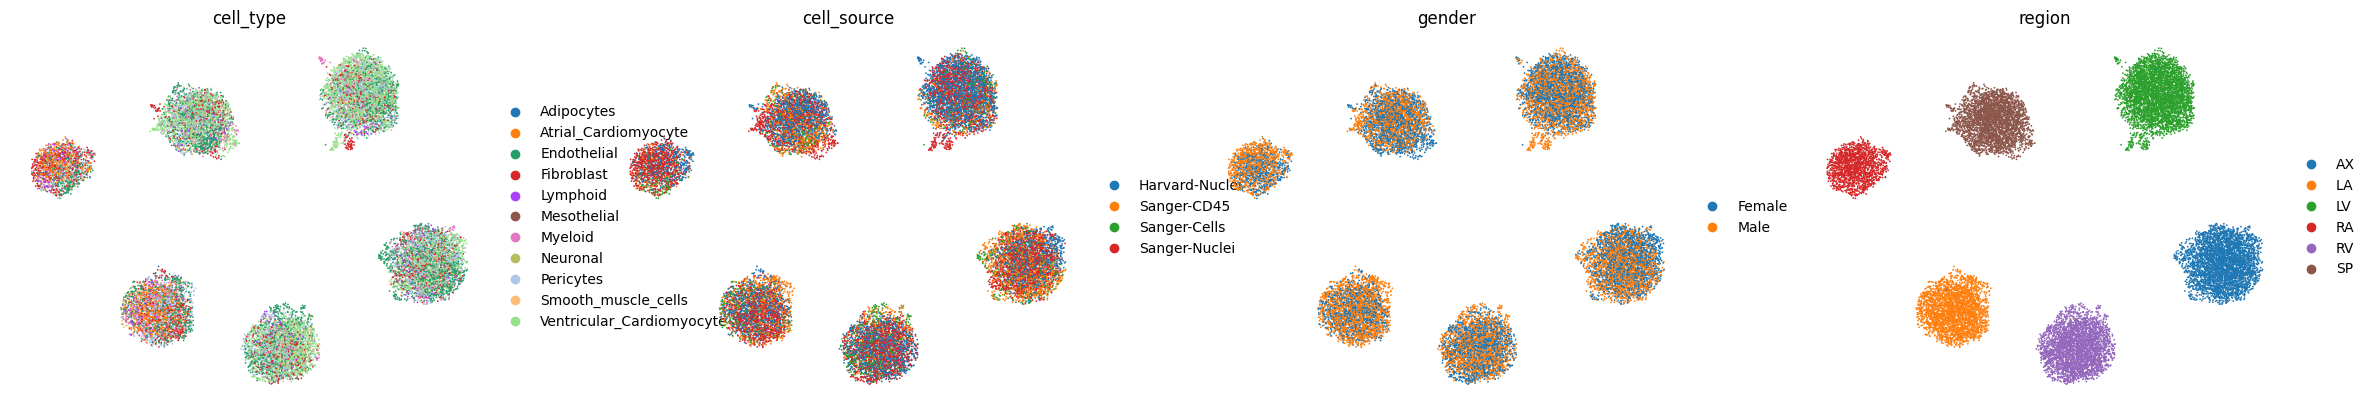

In [12]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )